# Exercise 8
## Fundamentals of Machine Learning, WiSe 20/21
### Authors: Catherine Knobloch, Elias Olofsson, Julia Siegl
    Version information:
        2021-02-19: v.1.0. First public release. 

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('image', cmap='gray')

from sklearn.datasets import load_digits
from sklearn import decomposition

# Produce inline vector graphics
%config InlineBackend.figure_format = 'svg'

## 2. Non-negative matrix factorization

In [2]:
# Importing the digits dataset
digits = load_digits()
X = digits["data"]/255.
Y = digits["target"]
print(X.shape, Y.shape)

(1797, 64) (1797,)


## 2.1 Comparison of scikit-learn's NMF with SVD (6 pts)

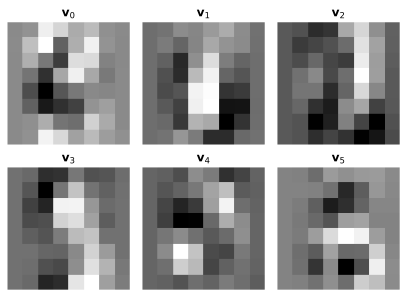

In [3]:
# Center the data for SVD
x_mean = X.mean(axis=0)
X_cent = X - x_mean

# Perform SVD
u, s, vh = np.linalg.svd(X_cent)

# Since numpy's SVD implementation sorts the singular values in descending order,
# we can simply index the first 6 columns of matrix vh, to acess the corresponding 
# basis vectors. Plotting these as images:
fsize = (5.6,4)
fig, ax = plt.subplots(2,3,figsize=fsize, constrained_layout=True, sharex=True,sharey=True)
ax = ax.flatten()
for i in range(6):
    ax[i].imshow((vh[i]+x_mean).reshape(8,8))
    ax[i].axis('off')
    ax[i].set_title(f'$\mathbf{{v}}_{{{i}}}$')
plt.show()

(1797, 10) (10, 64) (1797, 64)


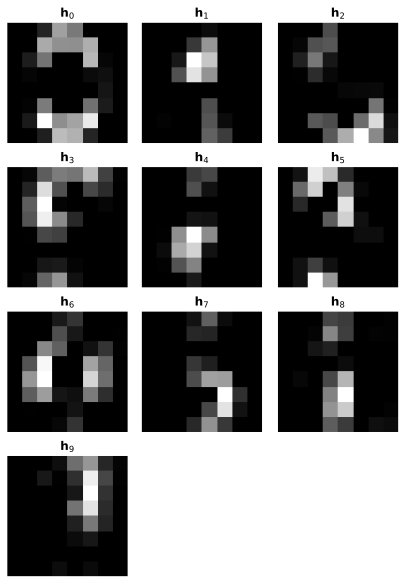

In [4]:
# Use sklearn's NMF implementation on X.
model = decomposition.NMF(n_components=10, init='random', random_state=0)
Z = model.fit_transform(X)
H = model.components_
print(Z.shape, H.shape, X.shape)

# Plot the basis vectors of H.
fsize = (5.6,8)
fig, ax = plt.subplots(4,3,figsize=fsize, constrained_layout=True, sharex=True,sharey=True)
ax = ax.flatten()
for i in range(10):
    ax[i].imshow(H[i].reshape(8,8))
    ax[i].axis('off')
    ax[i].set_title(f'$\mathbf{{h}}_{{{i}}}$')
fig.delaxes(ax[10])
fig.delaxes(ax[11])
plt.show()

## 2.2 Implementation (6 pts)

In [5]:
def non_negative(data, num_components, iterations=1000): 
    # Random initialization of Z and H. 
    Z = np.abs(np.random.normal(size=(data.shape[0], num_components)))
    H = np.abs(np.random.normal(size=(num_components, data.shape[1])))
    
    # Iteratively solve for Z and H
    res = []
    for t in range(iterations):
        # Update Z and H.
        H *= (Z.T @ data)/np.clip(Z.T @ Z @ H, a_min=1e-8, a_max=None)
        Z *= (data @ H.T)/np.clip(Z @ H @ H.T, a_min=1e-8, a_max=None)
        
        # Save residual
        res.append(0.5*np.linalg.norm(data-Z@H)**2)
    
    return Z, H, np.array(res)

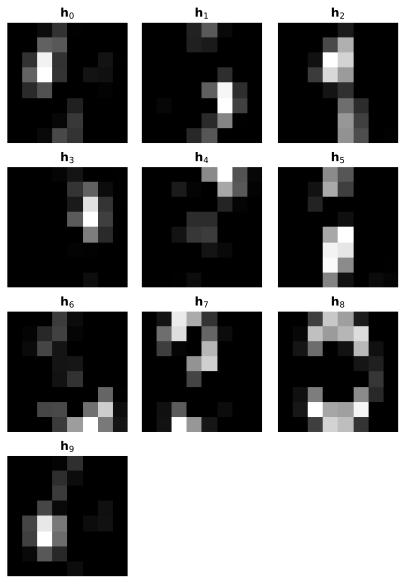

In [6]:
# Perform NMF of X using our own implementation.
Z, H, res = non_negative(X, num_components=10)

# Plot the basis vectors of H.
fsize = (5.6,8)
fig, ax = plt.subplots(4,3,figsize=fsize, constrained_layout=True, sharex=True,sharey=True)
ax = ax.flatten()
for i in range(10):
    ax[i].imshow(H[i].reshape(8,8))
    ax[i].axis('off')
    ax[i].set_title(f'$\mathbf{{h}}_{{{i}}}$')
fig.delaxes(ax[10])
fig.delaxes(ax[11])
plt.show()

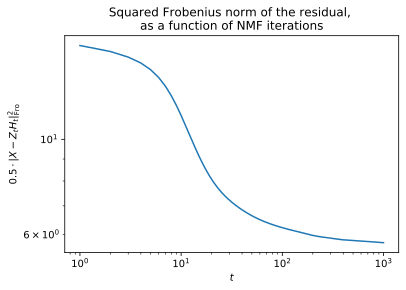

In [7]:
# Plot the evolution of the residual during the NMF in a loglog plot.
plt.loglog(1+np.arange(len(res)), res)
plt.xlabel('$t$')
plt.ylabel('$ 0.5 \cdot \|X-Z_t H_t\|_{\mathrm{Fro }}^{2}$')
plt.title('Squared Frobenius norm of the residual, \nas a function of NMF iterations')
plt.show()

# 3. Recommmender system (12 pts)

In [8]:
# Column headers for the dataset
users_cols = ['user id','age','gender','occupation','zip code']
movies_cols  = ['movie id','movie title','release date',
'video release date','IMDb URL','unknown','Action',
'Adventure','Animation','Childrens','Comedy','Crime',
'Documentary','Drama','Fantasy','Film-Noir','Horror',
'Musical','Mystery','Romance','Sci-Fi','Thriller',
'War','Western']
ratings_cols = ['user id','movie id','rating','timestamp']

# Import the datasets
users = pd.read_csv('ml-100k/u.user', sep='|', 
                    names=users_cols, encoding= 'latin-1')
movies = pd.read_csv('ml-100k/u.item', sep= '|', 
                     names=movies_cols, encoding='latin-1')
ratings = pd.read_csv('ml-100k/u.data', sep= '\t', 
                      names=ratings_cols, encoding='latin-1')

In [9]:
# Peek at the dataframes
users.head()

,user id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [10]:
movies.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [11]:
ratings.head()

,user id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Create a joint ratings dataframe for the matrix, using different methods for filling NaN-positions.

In [12]:
# Dataframe with NaN positions untouched.
rat_df_NaN = ratings.pivot(index='user id', columns='movie id', values='rating')

# Fill NaN:s with zeros.
fill_value = 0
rat_df = rat_df_NaN.fillna(fill_value)

# Fill NaN:s with total mean movie rating.
tot_mean_rating = rat_df_NaN.mean().mean()
rat_df_totmean  = rat_df_NaN.fillna(tot_mean_rating)

# Fill NaN:s with mean rating of each individual movie.
mean_rating = rat_df_NaN.mean()
rat_df_mean = rat_df_NaN.fillna(mean_rating)

In [13]:
def recommend_movies(reconstruction, user_id, movies, ratings, N):
    '''
    Get the best N movie suggestions for a chosen user.
    
    Parameters:
    -----------
    reconstruction: pandas.Dataframe
        NMF reconstruction of the original ratings matrix.
    user_id: int
        Unique identifier of the (single) chosen user.
    movies: pandas.Dataframe
        Dataframe containing all information on the movies in the database.
    ratings: pandas.Dataframe
        Dataframe containing the ratings of all users.
    N: int
        Number of movies to suggest.
    
    Returns:
    --------
    movie_suggestions: pandas.Series
        The top N suggestions for unwatched movies for the selected user, 
        with the corresponding predicted rating scores.
    '''
    # Extract the movies the current user has already seen (i.e. rated).
    movies_already_rated = ratings.loc[ratings['user id']==user_id, 'movie id'].values
    
    # Filter out previously seen movies from the reconstruction.
    movies_not_seen      = reconstruction.loc[user_id].drop(movies_already_rated)
    
    # Sort to obtain the N best suggestions for new movies.
    movie_suggestions    = movies_not_seen.sort_values(ascending=False)[:N]
    
    return movie_suggestions

In [14]:
# Set sequential colormap for the bar graphs.
cmap = 'viridis'
colors = getattr(plt.cm, cmap)(np.linspace(0,1,5))

def suggest_and_compare(reconstruction, user_id, movies, ratings, N):
    '''
    Get N movie suggestions for a given (single) user. Plot the genre distribution
    of the user's original ratings, and the distribution of the suggested movies.
    '''
    #---------------------------------------------------------------------------------
    # Get all movies rated by the current user, sort by movie id.
    df_user_rat = ratings[ratings['user id']==user_id].sort_values(by='movie id')
    
    # Extract the movie id:s and create a 'genre matrix' of the rated movies.    
    movies_rated = df_user_rat['movie id'].values
    df_genre_mat = movies[movies['movie id'].isin(movies_rated)].iloc[:,5:]
    
    # Add the ratings to the genre matrix
    df_genre_mat['rating'] = df_user_rat['rating'].values
    
    # Group by rating, and sum no. of movies per genre, per rating outcome. 
    df_genre_mat = df_genre_mat.groupby('rating').sum().T
    
    # Fix colors to specific rating outcomes (i.e. 5 = yellow, etc.) 
    col_idx = df_genre_mat.columns.values-1
    
    # Plot stacked bar graph for the original ratings.
    df_genre_mat.plot.bar(stacked=True, color=colors[col_idx], legend='reverse')
    plt.ylabel('No. of ratings')
    plt.title(f'All ratings given by user: {user_id}')
    plt.show()
    #---------------------------------------------------------------------------------
    # Get movie suggestions for the current user.
    suggestions = recommend_movies(reconstruction, user_id, movies, ratings, N)
    
    # Create a 'genre matrix' of the suggested movies.
    df_genre_mat = movies.loc[suggestions.index].iloc[:,5:]
    
    # Add the predicted ratings, round it up to nearest int.
    df_genre_mat['rating'] = np.ceil(np.clip(suggestions.values, 0, 5)).astype('int')
    
    # Group by rating, and sum no. of movies per genre, per rating outcome. 
    df_genre_mat = df_genre_mat.groupby('rating').sum().T
    
    # Fix colors to specific rating outcomes (i.e. 5 = yellow, etc.) 
    col_idx = df_genre_mat.columns.values-1
    
    # Plot stacked bar graph for the suggestions.
    df_genre_mat.plot.bar(stacked=True, color=colors[col_idx], legend='reverse')
    plt.ylabel('No. of suggestions')
    plt.title(f'Top {N} suggestions for user: {user_id}')
    plt.show()

In [15]:
# NMF on the ratings matrix.
#X = rat_df.to_numpy()
X = rat_df_totmean.to_numpy()
#X = rat_df_mean.to_numpy()

model = decomposition.NMF(n_components=20, init='random', random_state=0)
Z = model.fit_transform(X)
H = model.components_

# Reconstruct results from NMF into a new dataframe
reconstruction = pd.DataFrame(Z @ H, columns = rat_df.columns, index=rat_df.index)

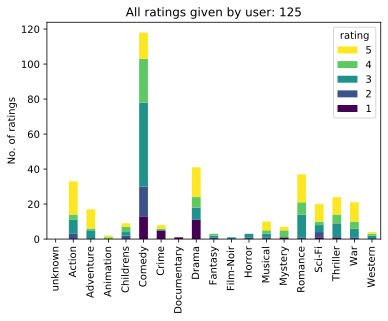

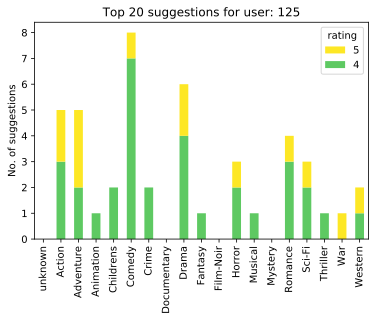

In [16]:
user_id = 125
suggest_and_compare(reconstruction, user_id, movies, ratings, N=20)

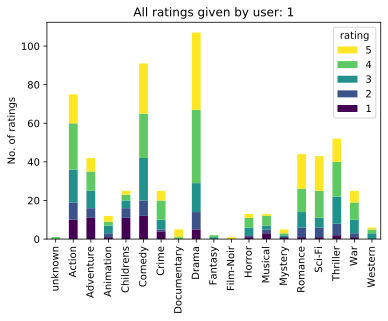

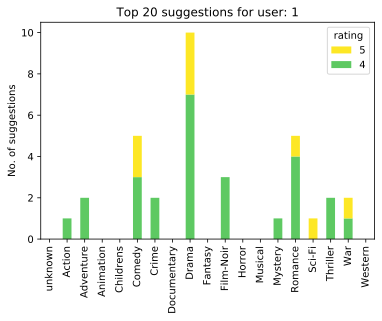

In [19]:
user_id = 1
suggest_and_compare(reconstruction, user_id, movies, ratings, N=20)